In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms

from PIL import Image
import matplotlib.pyplot as plt
import time
import os
import copy

C:\Users\Ripon\Anaconda3\envs\MLDL\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


from PIL import Image

img = Image.open('./EPM_12_image/2610.png')
plt.imshow(img)

img3 = np.asarray(img)[150:850, 250:950]
plt.imshow(img3)

img3.shape

df = pd.DataFrame(df)

In [2]:
# need to crop all the images to get only the mouse image
# rading xlxs files for the images and labels
import pandas as pd
df = pd.read_excel('./EMP_12xlsx.xlsx')
print(df.columns)
#df['frame'], df['label']
#dropping null values
df = df.dropna()
images = [f'./EPM_12_image/{int(i)}.png' for i in df['frame']]
labels = df['label']

Index(['frame', 'label'], dtype='object')


img = Image.open(images[1])
plt.imshow(img)

In [3]:
len(images), len(labels)

(300, 300)

In [4]:
# there are seperate transfromation func for PIL and Tensor. SO chcek again if you are using the correct ones
def get_train_transform():
    return torchvision.transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.GaussianBlur(kernel_size=(5,9), sigma=(0.1, 5)),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    transforms.RandomRotation(degrees=(0,100)),
    #transforms.RandomInvert(),
    #transforms.RandomAdjustSharpness(sharpness_factor=2),isnot a good choice for the dataste
    #transforms.RandomAutocontrast(), isnot a good choice for the dataste
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
])

def get_test_transform():
    return torchvision.transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224))])

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, 
                                             test_size=0.30, random_state=42)

In [7]:
y_train = [i for i in y_train]
y_test = [i for i in y_test]

In [8]:
len(X_train), len(X_test), len(y_train), len(y_test)

(210, 90, 210, 90)

In [9]:
np.unique(y_train),len(np.unique(y_train)), np.unique(y_test), len(np.unique(y_test))

(array(['heading up', 'heading up and rearing', 'moving alone', 'rearing',
        'stopeed alone', 'stopeed huddled', 'stoping alone',
        'stopped alone', 'stopped huddled', 'stretched attennd posture'],
       dtype='<U25'),
 10,
 array(['heading up', 'heading up and rearing', 'moving alone',
        'stopeed huddled', 'stopped alone', 'stopped huddled',
        'stretched attennd posture'], dtype='<U25'),
 7)

In [10]:
labels.unique(), len(labels.unique())

(array(['moving alone', 'stoping alone', 'heading up', 'rearing',
        'stopped huddled', 'heading up and rearing', 'stopped alone',
        'stopeed huddled', 'stretched attennd posture', 'stopeed alone'],
       dtype=object),
 10)

In [11]:
#counting data for each label
labels_count = [len(labels[labels==i]) for i in labels.unique()]
labels_count

[109, 1, 45, 9, 53, 44, 27, 3, 8, 1]

In [12]:
#assigning class index to every class
classes = labels.unique()

for cls in classes:
    class_to_int = {classes[i]: i for i in range(len(classes))}
class_to_int

{'moving alone': 0,
 'stoping alone': 1,
 'heading up': 2,
 'rearing': 3,
 'stopped huddled': 4,
 'heading up and rearing': 5,
 'stopped alone': 6,
 'stopeed huddled': 7,
 'stretched attennd posture': 8,
 'stopeed alone': 9}

In [13]:
### Loading Classification Dataset: Using iterator.
# In the secind case using ___getitem__ is used for reading each imagemr

from torch.utils.data import DataLoader,Dataset
class MiceDataset(Dataset):
    
    def __init__(self, data_set, class_labels, class_to_int, transforms = None):
        
        super().__init__()
        self.data_set = data_set
        self.class_to_int = class_to_int
        self.class_labels = class_labels
        self.transforms = transforms
        
        
    def __getitem__(self, index):
        
        image= Image.open(self.data_set[index])
        #croping image
        image = np.asarray(image)[150:850, 250:950]
        
        label = self.class_labels[index]
        label = self.class_to_int[label]
        
        
        #Applying transforms on image
        if self.transforms:
            image = self.transforms(image)
        
        #return image, label
        return image, label
        
    #its not important though   
    def __len__(self):
        #print (len(self.imgs_list))
        return (len(self.data_set))

In [14]:
import torchvision.transforms
train_dataset = MiceDataset(X_train, y_train, class_to_int, transforms=get_train_transform())
test_dataset = MiceDataset(X_test, y_test, class_to_int, transforms=get_test_transform())

In [17]:
from torch.utils.data import random_split, RandomSampler
#Data Loader  -  using Sampler 
train_random_sampler = RandomSampler(train_dataset)
test_random_sampler = RandomSampler(test_dataset)

# dataloader
train_data_loader = DataLoader(dataset=train_dataset, batch_size=16, sampler=train_random_sampler, num_workers=0)
test_data_loader = DataLoader(dataset=test_dataset, batch_size=16, sampler=test_random_sampler, num_workers=0)

In [18]:
next(iter(train_data_loader))

[tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0

In [19]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)    

In [20]:
device = get_default_device()
device

device(type='cuda')

# Transfering data to the device in use (In our case GPU)
train_dl = DeviceDataLoader(train_data_loader, device)
valid_dl = DeviceDataLoader(test_data_loader, device)

In [21]:
dataloaders = {'train':train_data_loader, 'test':test_data_loader}

In [22]:
dataset_sizes = {'train':len(X_train), 'test':len(X_test)}

In [23]:
from PIL import Image

next(iter(train_data_loader))

#training

In [24]:
from tqdm import tqdm
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    result = {'train_acc':[], 'train_loss':[], 'valid_acc':[], 'valid_loss':[]}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
                #print('training...')
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                #print('dataloader phase: training')

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    #outputs = model(inputs).softmax(dim=1)
                    
                    '''printing '''
                    #print(f'outputs: {outputs}')
                    '''trying out the softmax'''
                    #print(f'softmax: {outputs.softmax(dim=1)}')
                    
                    pred_values, preds_indc = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    '''printing '''
                   # print(f'loss: {loss}')

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds_indc == labels.data)
                '''can be done something here for calculating accuracy
                but I donot know how to use the prediction value to calculate the accuracy'''
                
                
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            #print(outputs) # wanna see the outputs
            
            if phase =='train':
                result['train_acc'].append(epoch_acc)
                result['train_loss'].append(epoch_loss)
            else:
                result['valid_acc'].append(epoch_acc)
                result['valid_loss'].append(epoch_loss)

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
    #print(result)

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, result

In [25]:
#visualizr and model prediction

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            #outputs = model(inputs).softmax(dim=1)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]) + class_names[labels[j]])
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [26]:
model_ft = models.resnet152(pretrained=True)

In [27]:
num_ftrs = model_ft.fc.in_features
print(num_ftrs)

2048


In [28]:
#model_ft.fc = nn.Linear(num_ftrs, 6, bias=True)
num_classes = len(labels.unique())
model_ft.fc = nn.Sequential(nn.Linear(2048, num_classes))

model_ft = model_ft.to(device)


In [29]:
num_classes

10

##claculating weights for each class
samples = []
samples = torch.tensor([len(all_files[keys]) for keys in all_files.keys()])
sam_weights = samples/torch.sum(samples)
inv_samples = 1/sam_weights
loss_weight = inv_samples/torch.sum(inv_samples)
loss_weight = loss_weight.to(device)
loss_weight

In [30]:
#train and evaluate
#wts = torch.tensor([0.48, 0.15, 0.11, 0.2, 0.06]).to(device)

#criterion = nn.CrossEntropyLoss(weight=loss_weight)3 with weighted loss
criterion = nn.CrossEntropyLoss()  # without weighted loss
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.9)
num_epochs=10
model_ft, result = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=num_epochs)

Epoch 0/9
----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:20<00:00,  1.43s/it]


train Loss: 2.0917 Acc: 0.2619


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:04<00:00,  1.24it/s]


test Loss: 1.7998 Acc: 0.1111
Epoch 1/9
----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:14<00:00,  1.02s/it]


train Loss: 1.9999 Acc: 0.2143


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:04<00:00,  1.40it/s]


test Loss: 1.6705 Acc: 0.4333
Epoch 2/9
----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:16<00:00,  1.18s/it]


train Loss: 1.8783 Acc: 0.2381


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.05s/it]


test Loss: 1.6944 Acc: 0.4333
Epoch 3/9
----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:17<00:00,  1.22s/it]


train Loss: 1.8678 Acc: 0.3143


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:04<00:00,  1.31it/s]


test Loss: 1.8578 Acc: 0.1667
Epoch 4/9
----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:14<00:00,  1.04s/it]


train Loss: 1.7751 Acc: 0.3333


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:04<00:00,  1.48it/s]


test Loss: 1.7423 Acc: 0.4333
Epoch 5/9
----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:14<00:00,  1.05s/it]


train Loss: 1.7785 Acc: 0.3238


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:04<00:00,  1.43it/s]


test Loss: 1.7532 Acc: 0.4333
Epoch 6/9
----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:14<00:00,  1.03s/it]


train Loss: 1.6710 Acc: 0.3905


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:04<00:00,  1.38it/s]


test Loss: 1.6713 Acc: 0.4333
Epoch 7/9
----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:14<00:00,  1.02s/it]


train Loss: 1.6473 Acc: 0.3714


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:04<00:00,  1.32it/s]


test Loss: 1.7282 Acc: 0.4333
Epoch 8/9
----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:14<00:00,  1.03s/it]


train Loss: 1.5765 Acc: 0.3810


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:04<00:00,  1.37it/s]


test Loss: 1.7496 Acc: 0.4333
Epoch 9/9
----------


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:14<00:00,  1.04s/it]


train Loss: 1.6041 Acc: 0.3810


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:04<00:00,  1.50it/s]

test Loss: 1.6307 Acc: 0.4333
Training complete in 3m 23s
Best val Acc: 0.433333


In [31]:
train_accuracy = [x.cpu() for x in result['train_acc']]
test_accuracy = [x.cpu() for x in result['valid_acc']]

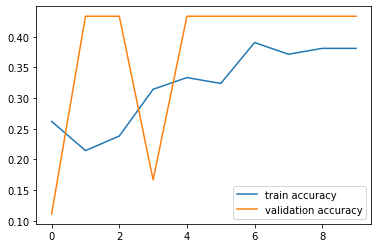

In [32]:

#plotting the performace
fig, ax = plt.subplots()
train_acc,  = ax.plot(train_accuracy, label='train accuracy')
valid_acc,  = ax.plot(test_accuracy, label='validation accuracy')

#l1,  = ax.plot([1,2,3], label="Line 1")
#l2, = ax.plot([2,3,4], label="Line 2")
ax.legend(handles=[train_acc, valid_acc], loc='lower right')

plt.show()

In [ ]:
I need to prepare proper dataset

Need to prepare the test script to produce csv result from the video
then work on the visual data generation
implementation of kmeans clusturing and differnt visualization method for showing proper data analysis.